In [167]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, RegressorMixin
import seaborn as sns

In [168]:
DATA_DIR = '../data/machine.data'

In [169]:
column_names = ['vendor_name', 'model_name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df = pd.read_csv(DATA_DIR, names=column_names, delimiter=',')
df.head()

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [170]:
nan_info = df.isna().sum()
print(nan_info)

vendor_name    0
model_name     0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
ERP            0
dtype: int64


# Convert categorical features to real ones

In [171]:
df['vendor_name'] = pd.factorize(df['vendor_name'])[0]
df

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,0,32/60,125,256,6000,256,16,128,198,199
1,1,470v/7,29,8000,32000,32,8,32,269,253
2,1,470v/7a,29,8000,32000,32,8,32,220,253
3,1,470v/7b,29,8000,32000,32,8,32,172,253
4,1,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,27,80/8,124,1000,8000,0,1,8,42,37
205,27,90/80-model-3,98,1000,8000,32,2,8,46,50
206,28,32,125,2000,8000,0,2,14,52,41
207,29,vs-100,480,512,8000,32,0,0,67,47


In [172]:
df['model_name'] = pd.factorize(df['model_name'])[0]
df

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,0,0,125,256,6000,256,16,128,198,199
1,1,1,29,8000,32000,32,8,32,269,253
2,1,2,29,8000,32000,32,8,32,220,253
3,1,3,29,8000,32000,32,8,32,172,253
4,1,4,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,27,204,124,1000,8000,0,1,8,42,37
205,27,205,98,1000,8000,32,2,8,46,50
206,28,206,125,2000,8000,0,2,14,52,41
207,29,207,480,512,8000,32,0,0,67,47


# Visualization

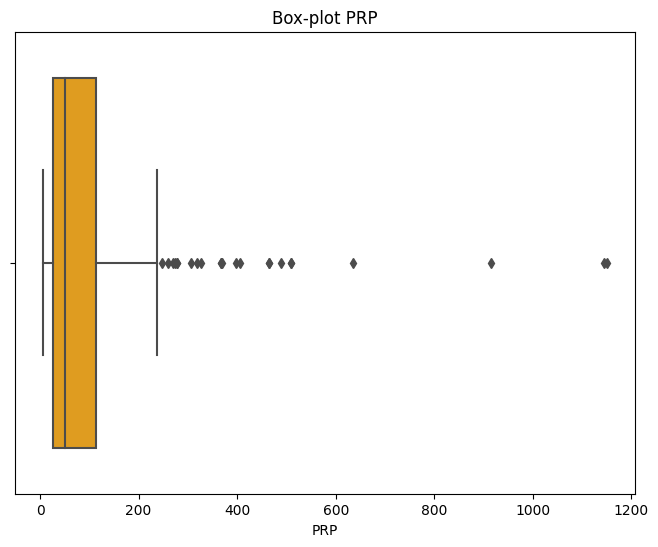

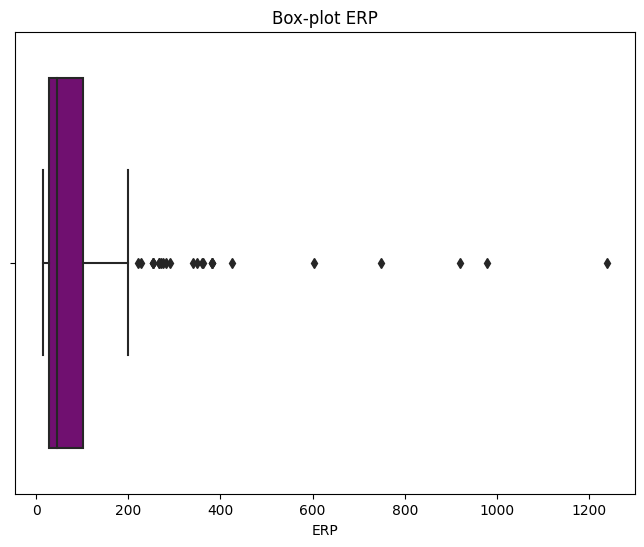

In [173]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='PRP', data=df, color='orange')
plt.title('Box-plot PRP')
plt.xlabel('PRP')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='ERP', data=df, color='purple')
plt.title('Box-plot ERP')
plt.xlabel('ERP')
plt.show()

# Data normalization

In [174]:
scaler = StandardScaler()
numeric_columns = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [175]:
df.head()

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,0,0,-0.303586,-0.675026,-0.495462,5.694208,1.661989,4.231033,0.575759,0.645587
1,1,1,-0.673330,1.326291,1.727049,0.167629,0.485509,0.529479,1.018277,0.995359
2,1,2,-0.673330,1.326291,1.727049,0.167629,0.485509,0.529479,0.712877,0.995359
3,1,3,-0.673330,1.326291,1.727049,0.167629,0.485509,0.529479,0.413710,0.995359
4,1,4,-0.673330,1.326291,0.359350,0.167629,0.485509,-0.087447,0.164405,0.211611


# SVR

In [176]:
X = df.drop(columns=['ERP'])
y = df['ERP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

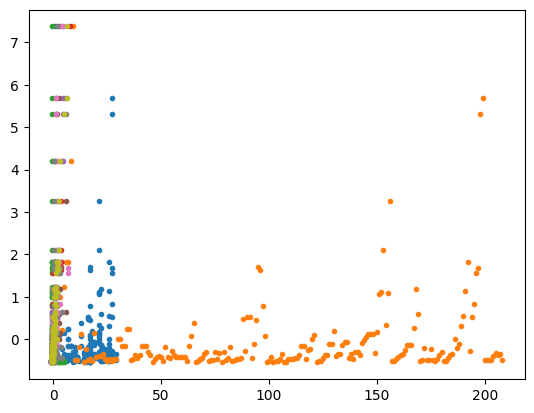

In [177]:
plt.plot(X, y, '.')
plt.show()

In [178]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [179]:
param_dist = {
    'C': np.logspace(-3, 3, 100),
    'epsilon': np.linspace(0.01, 0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 100)
}

In [180]:
svr = SVR()

random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_dist, n_iter=100,
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

with tqdm(total=100, desc="Hyperparameter Tuning") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(100)

Hyperparameter Tuning: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


In [181]:
best_params = random_search.best_params_
best_params

{'kernel': 'rbf',
 'gamma': 0.006135907273413176,
 'epsilon': 0.07,
 'C': 141.74741629268047}

In [182]:
best_svr = SVR(**best_params)
best_svr.fit(X_train, y_train)

SVR(C=141.74741629268047, epsilon=0.07, gamma=0.006135907273413176)

In [183]:
y_pred = best_svr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", best_params)
print("MSE:", mse)
print("R^2:", r2)

Best parameters: {'kernel': 'rbf', 'gamma': 0.006135907273413176, 'epsilon': 0.07, 'C': 141.74741629268047}
MSE: 0.11472336902077325
R^2: 0.949133082023322


In [184]:
results_svr = {
    'Model': 'SVR',
    'MSE': mse,
    'R^2': r2
}

# Nadray-Watson method

In [185]:
def K(distance, h=0.2):
    ret = np.array(distance) / h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [186]:
class FNVRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel=None, h=None, alpha=0.1):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
        self.h = h
        self.alpha = alpha
    
    def predict(self, X):
        features = np.sum(self.Y * self.kernel(cdist(X, self.X), h=self.h), axis=-1)
        return features / (np.sum(self.kernel(cdist(X, self.X), h=self.h), axis=-1) + 1e-10)
    
    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

    def score(self, X, y):
        y_pred = self.predict(X)
        r2 = r2_score(y, y_pred)
        return r2


In [187]:
param_dist = {
    'h': np.linspace(0.0001, 10.0, 1000),
    'alpha': np.logspace(-7, 7, 1000),  
}

In [188]:
fnv_regressor = FNVRegressor(kernel=K)

random_search = RandomizedSearchCV(estimator=fnv_regressor, param_distributions=param_dist, n_iter=100,
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

with tqdm(total=100, desc="Hyperparameter Tuning") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(100)

Hyperparameter Tuning: 100%|██████████| 100/100 [00:00<00:00, 206.67it/s]


In [189]:
best_params = random_search.best_params_
best_params

{'h': 3.5536180180180184, 'alpha': 2.776153294436798e-06}

In [190]:
best_fnv_regressor = FNVRegressor(kernel=K, **best_params)
best_fnv_regressor.fit(X_train, y_train)

y_pred = best_fnv_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", best_params)
print("MSE:", mse)
print("r2:", r2)

Best parameters: {'h': 3.5536180180180184, 'alpha': 2.776153294436798e-06}
MSE: 1.3314204947235566
r2: 0.4096646770780592


In [191]:
results_fnv = {
    'Model': 'FNV',
    'MSE': mse,
    'R^2': r2
}

# Comparison of models

In [193]:
results_list = [results_svr, results_fnv]
results_df = pd.DataFrame(results_list)

In [197]:
results_df

,Model,MSE,R^2
0,SVR,0.114723,0.949133
1,FNV,1.331420,0.409665


# Conclusion

In comparing the two models, SVR and FNV, based on their Mean Squared Error (MSE) and R-squared (R^2) scores, we can draw the following conclusions:

1. SVR Model:
    - MSE: 0.114723
    - R^2: 0.949133

    The SVR model demonstrates strong performance with a low MSE value of 0.114723 and a high R^2 score of 0.949133. These results indicate that the SVR model provides a very good fit to the data, with relatively small prediction errors and a high proportion of variance explained by the model.

1. FNV Model:
    - MSE: 1.331420
    - R^2: 0.409665

    In contrast, the FNV model exhibits higher prediction errors with an MSE of 1.331420 and a lower R^2 score of 0.409665. These results suggest that the FNV model performs less well in capturing the underlying patterns in the data, as indicated by the higher MSE and the lower R^2 score.

The SVR model outperforms the FNV model in terms of both MSE and R^2. It provides a better fit to the data and is better at explaining the variance in the target variable. Therefore, based on these metrics, the SVR model is the preferred choice for this particular regression task.